<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/ANL488_Proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Historical Price Data for SPY from Yahoo Finance

In [15]:
#Import libraries
import yfinance as yf
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

## Daily MACD

In [2]:
ticker = "SPY"
data = yf.download(ticker, start="2022-08-01", end="2024-08-01")

# Reset the index to move the 'Date' index into a regular column
data.reset_index(inplace=True)

print(data.head())

[*********************100%***********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2022-08-01  409.149994  413.410004  408.399994  410.769989  398.594666   
1 2022-08-02  409.119995  413.000000  406.820007  408.059998  395.965057   
2 2022-08-03  410.299988  415.679993  410.000000  414.450012  402.165649   
3 2022-08-04  414.369995  415.089996  412.440002  414.170013  401.893951   
4 2022-08-05  409.660004  414.149994  409.600006  413.470001  401.214630   

     Volume  
0  69997500  
1  63435400  
2  67820600  
3  45656600  
4  56814900  


In [3]:
# Calculate MACD and Signal Line

# 12-period EMA
short_ema = data['Adj Close'].ewm(span=12, adjust=False).mean()

# 26-period EMA
long_ema = data['Adj Close'].ewm(span=26, adjust=False).mean()

# MACD Line
macd = short_ema - long_ema

# Signal Line
signal_line = macd.ewm(span=9, adjust=False).mean()

# Add the MACD and Signal Line to the DataFrame
data['MACD'] = macd
data['Signal Line'] = signal_line

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line
0,2022-08-01,409.149994,413.410004,408.399994,410.769989,398.594666,69997500,0.000000,0.000000
1,2022-08-02,409.119995,413.000000,406.820007,408.059998,395.965057,63435400,-0.209769,-0.041954
2,2022-08-03,410.299988,415.679993,410.000000,414.450012,402.165649,67820600,0.122906,-0.008982
3,2022-08-04,414.369995,415.089996,412.440002,414.170013,401.893951,45656600,0.360475,0.064909
4,2022-08-05,409.660004,414.149994,409.600006,413.470001,401.214630,56814900,0.488305,0.149589


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         503 non-null    datetime64[ns]
 1   Open         503 non-null    float64       
 2   High         503 non-null    float64       
 3   Low          503 non-null    float64       
 4   Close        503 non-null    float64       
 5   Adj Close    503 non-null    float64       
 6   Volume       503 non-null    int64         
 7   MACD         503 non-null    float64       
 8   Signal Line  503 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 35.5 KB


## Exploratory Data Analysis (EDA)

In [5]:
# Summary statistics
print(data.describe())

                                Date        Open        High         Low  \
count                            503  503.000000  503.000000  503.000000   
mean   2023-07-30 19:02:15.984095232  445.498907  447.941651  443.032803   
min              2022-08-01 00:00:00  349.209991  359.820007  348.109985   
25%              2023-01-30 12:00:00  403.395004  406.184998  400.985001   
50%              2023-08-01 00:00:00  435.049988  436.989990  433.010010   
75%              2024-01-30 12:00:00  488.214996  490.325012  486.855011   
max              2024-07-31 00:00:00  562.869995  565.159973  562.099976   
std                              NaN   52.770769   52.369083   53.094036   

            Close   Adj Close        Volume        MACD  Signal Line  
count  503.000000  503.000000  5.030000e+02  503.000000   503.000000  
mean   445.645428  439.747049  7.688059e+07    2.071897     2.054473  
min    356.559998  347.412720  2.728970e+07  -11.216420    -9.494298  
25%    404.274994  395.088760  

In [7]:
# Check for missing values
print(data.isnull().sum())

Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
MACD           0
Signal Line    0
dtype: int64


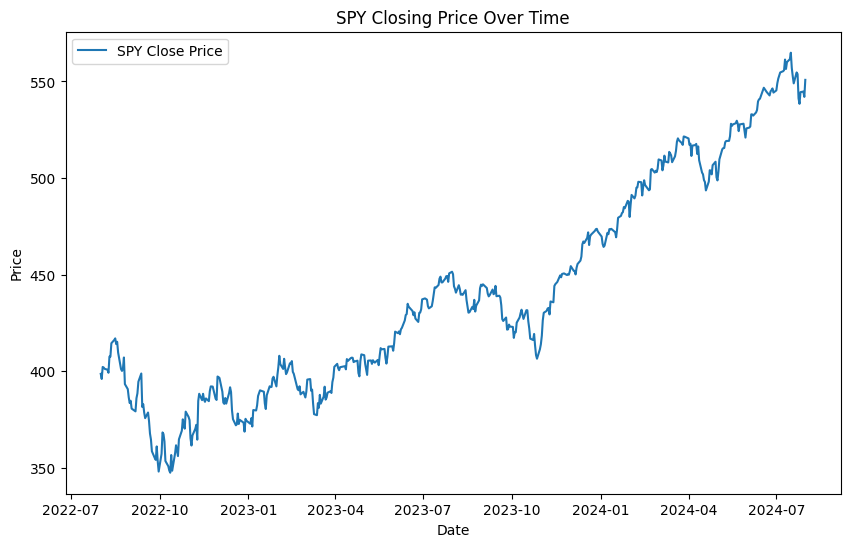

In [6]:
# Plot the adjusted closing price over the past 2 years
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Adj Close'], label='SPY Close Price')
plt.title('SPY Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

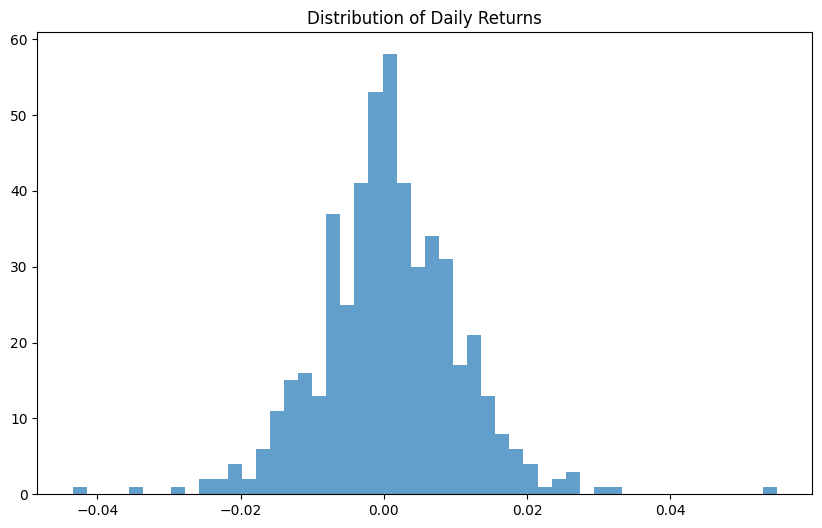

In [8]:
# Distribution of daily returns in percentage
data['Daily Return'] = data['Adj Close'].pct_change()
plt.figure(figsize=(10, 6))
plt.hist(data['Daily Return'].dropna(), bins=50, alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.show()

## MACD and Signal line crossovers

In [9]:
# MACD crosses above the Signal Line (buy signal)
data['macd_cross_above'] = (data['MACD'] > data['Signal Line']) & (data['MACD'].shift(1) <= data['Signal Line'].shift(1))

# MACD crosses below the Signal Line (sell signal)
data['macd_cross_below'] = (data['MACD'] < data['Signal Line']) & (data['MACD'].shift(1) >= data['Signal Line'].shift(1))

# Convert crossover conditions to boolean for easier interpretation
data['macd_cross_above'] = data['macd_cross_above'].astype(bool)
data['macd_cross_below'] = data['macd_cross_below'].astype(bool)

# To review the filtered DataFrame where crossovers occur, filter by True values:
buy_signals = data[data['macd_cross_above'] == True]
sell_signals = data[data['macd_cross_below'] == True]

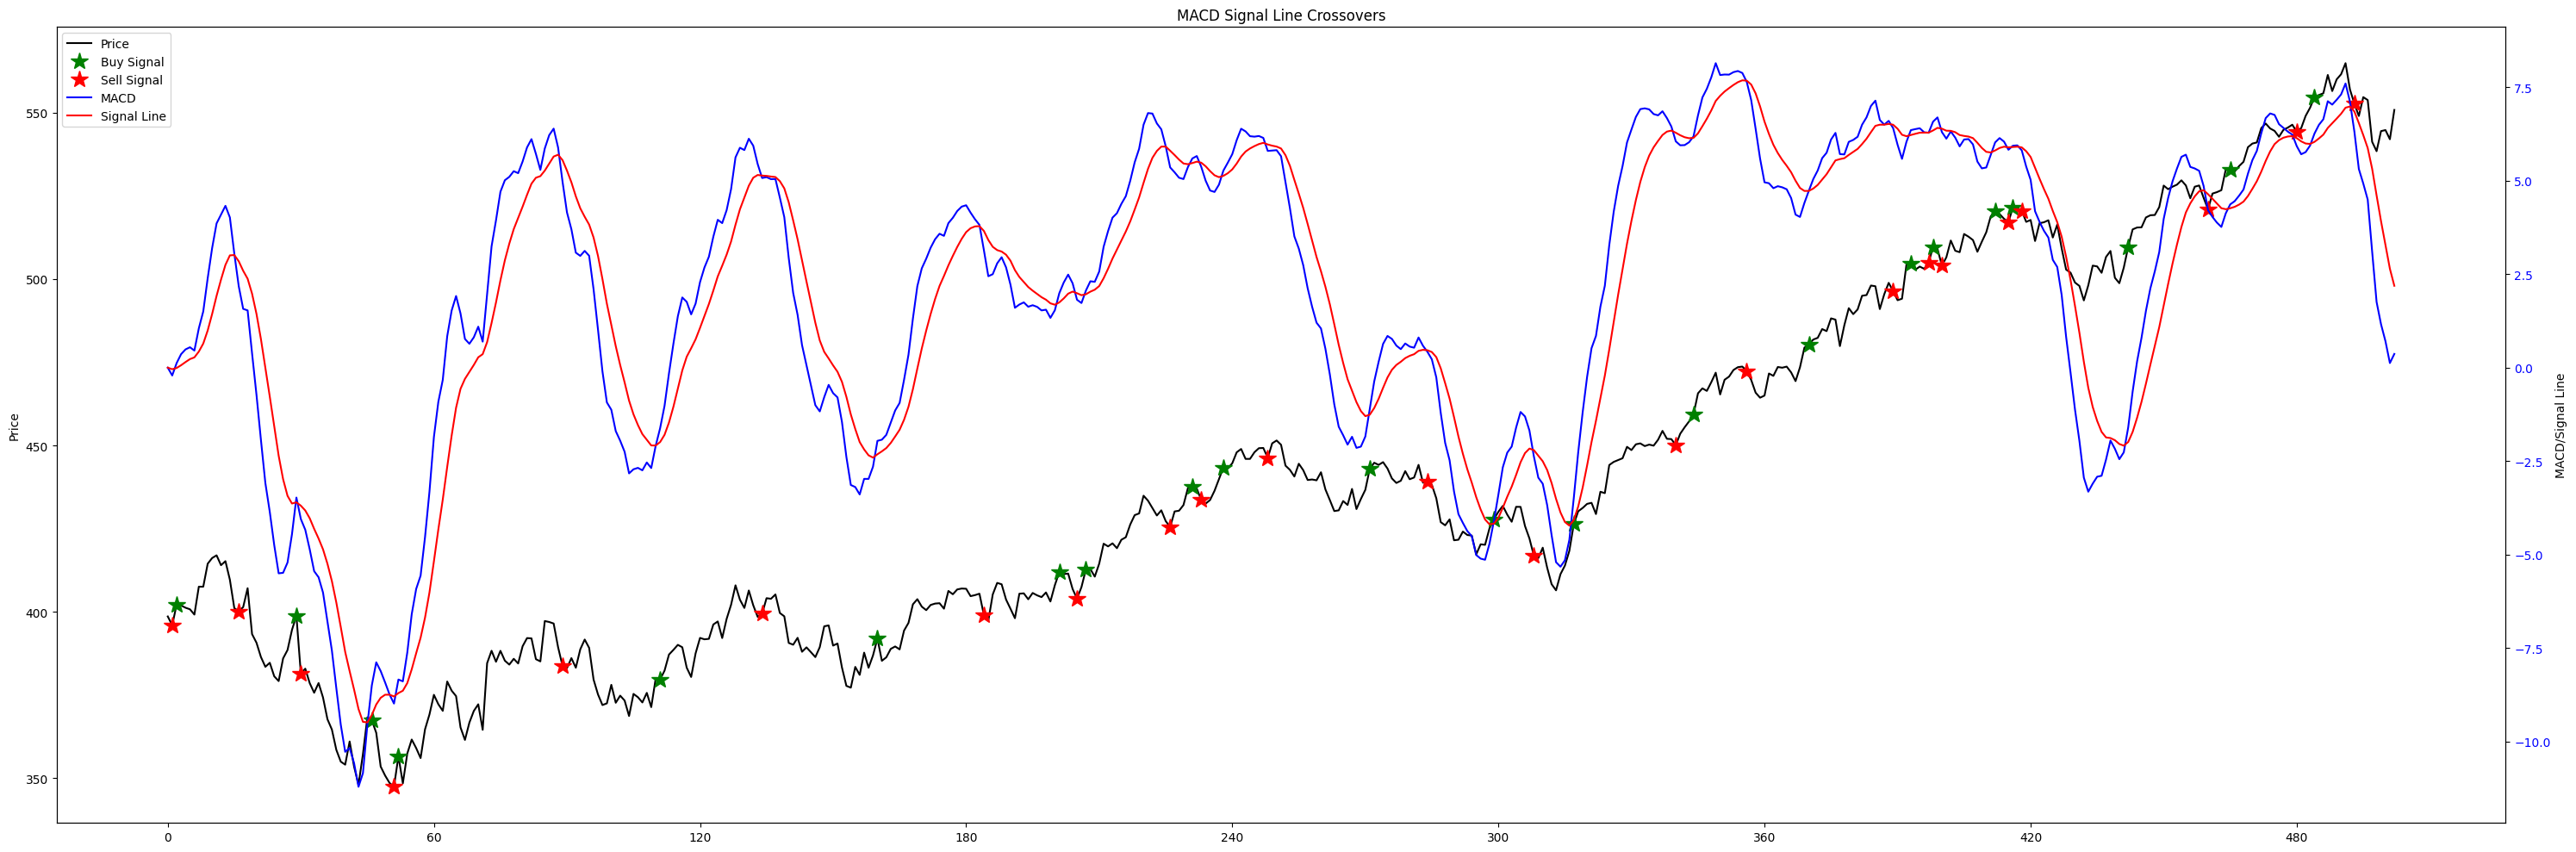

In [10]:
# Create a figure and a set of subplots with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(30, 10))

# Set the title
plt.title("MACD Signal Line Crossovers")

# Plot the Adjusted Closing Price on the primary y-axis (ax1)
ax1.plot(data['Adj Close'], label="Price", color="black")
ax1.set_ylabel("Price")
ax1.tick_params(axis='y', labelcolor="black")

# Create a secondary y-axis (ax2) for MACD and Signal Line
ax2 = ax1.twinx()
ax2.plot(data['MACD'], label="MACD", color="blue")
ax2.plot(data['Signal Line'], label="Signal Line", color="red")
ax2.set_ylabel("MACD/Signal Line")
ax2.tick_params(axis='y', labelcolor="blue")

# Highlight buy signals (green stars) on the price plot
for idx in buy_signals.index.tolist():
    ax1.plot(
        idx,
        data.loc[idx]["Adj Close"],
        "g*",
        markersize=15,
        label="Buy Signal" if idx == buy_signals.index.tolist()[0] else ""
    )

# Highlight sell signals (red stars) on the price plot
for idx in sell_signals.index.tolist():
    ax1.plot(
        idx,
        data.loc[idx]["Adj Close"],
        "r*",
        markersize=15,
        label="Sell Signal" if idx == sell_signals.index.tolist()[0] else ""
    )

# Configure x-axis labels
plt.xticks(rotation=90)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show fewer x-ticks for readability

# Final touches: Combine legends from both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Display the plot
plt.tight_layout()
plt.show()

## Feature Selection

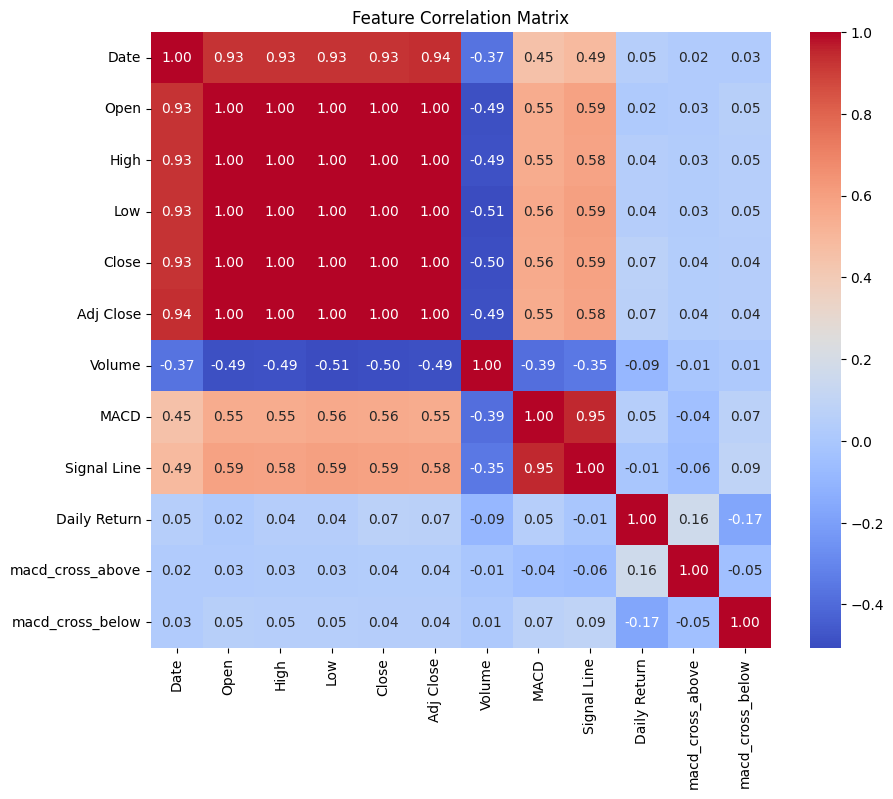

In [11]:
import seaborn as sns

# Correlation matrix for the features
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()